In [1]:
import time

start_time = time.time()

In [2]:
from os import listdir
import matplotlib.pyplot as plt
from imutils import paths
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import tensorflow as tf

2023-02-22 18:45:07.815228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Look at data folder structure
classes_dir = listdir("data/Kather_texture_2016_image_tiles_5000")
classes_dir

['02_STROMA',
 '06_MUCOSA',
 '.DS_Store',
 '05_DEBRIS',
 '01_TUMOR',
 '03_COMPLEX',
 '08_EMPTY',
 '04_LYMPHO',
 '07_ADIPOSE']

In [4]:
# Check files
files = listdir("data/Kather_texture_2016_image_tiles_5000/01_TUMOR")
for n in range(5):
    print(files[n])

10B61_CRC-Prim-HE-09_022.tif_Row_301_Col_1.tif
4D50_CRC-Prim-HE-04_034.tif_Row_1_Col_601.tif
12A0_CRC-Prim-HE-07_025.tif_Row_451_Col_1.tif
5F7E_CRC-Prim-HE-04_015.tif_Row_1_Col_151.tif
7BA4_CRC-Prim-HE-07_006.tif_Row_1_Col_151.tif


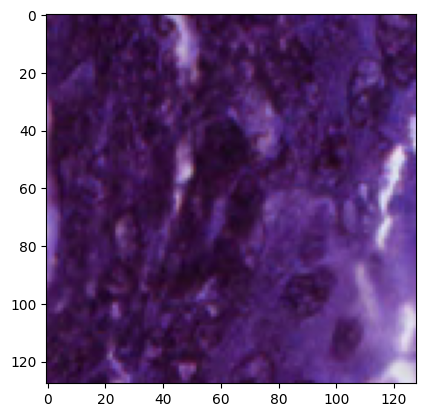

In [5]:
# visualize example image
file = cv2.imread("data/Kather_texture_2016_image_tiles_5000/01_TUMOR/1A11_CRC-Prim-HE-07_022.tif_Row_601_Col_151.tif")
# file = cv2.cvtColor(file, cv2.COLOR_BGR2RGB)
file = cv2.resize(file, (128, 128))
plt.imshow(file)

In [6]:
# Load data
print("[INFO] loading images...")
imagePaths = list(paths.list_images("data/Kather_texture_2016_image_tiles_5000"))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = (imagePath.split(os.path.sep)[-2][1])
    # Since we are going to use MobileNetV2 we need to resize the images
    # to the expected size by the pre-trained network.
    image = load_img(imagePath, target_size=(128, 128))
    image = img_to_array(image)
    image = preprocess_input(image)
    image = tf.cast(image, tf.float32) / 255.0 #normalize
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


2023-02-22 18:45:18.644549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
data.shape

(5000, 128, 128, 3)

In [8]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# labels = to_categorical(labels)
print(labels[0], labels[0][0], type(labels[0]))

[0 1 0 0 0 0 0 0] 0 <class 'numpy.ndarray'>


In [9]:
# Split into train, val, test set
x, x_test, y, y_test = train_test_split(data, labels, test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.25,train_size =0.75)

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
tf.keras.backend.clear_session()

In [12]:
BS = 256
IMG_SHAPE = 128
EPOCHS = 40

In [13]:
aug = ImageDataGenerator(
    rotation_range=45,
    zoom_range=0.3,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    )

In [14]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))

In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
history3=model.fit(x_train,
                y_train,
                batch_size=BS,
                #steps_per_epoch=STEPS,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                )
                #validation_steps=STEPS)

Epoch 1/40
12/12 [==============================] - 27s 2s/step - loss: 1.9620 - accuracy: 0.2230 - val_loss: 1.6083 - val_accuracy: 0.3150
Epoch 2/40
12/12 [==============================] - 23s 2s/step - loss: 1.4396 - accuracy: 0.3500 - val_loss: 1.2716 - val_accuracy: 0.4250
Epoch 3/40
12/12 [==============================] - 19s 2s/step - loss: 1.3141 - accuracy: 0.4057 - val_loss: 1.2417 - val_accuracy: 0.4120
Epoch 4/40
12/12 [==============================] - 16s 1s/step - loss: 1.2170 - accuracy: 0.4417 - val_loss: 1.1463 - val_accuracy: 0.4930
Epoch 5/40
12/12 [==============================] - 16s 1s/step - loss: 1.1236 - accuracy: 0.4990 - val_loss: 1.0378 - val_accuracy: 0.6020
Epoch 6/40
12/12 [==============================] - 15s 1s/step - loss: 1.0665 - accuracy: 0.5337 - val_loss: 1.0948 - val_accuracy: 0.5240
Epoch 7/40
12/12 [==============================] - 15s 1s/step - loss: 1.0368 - accuracy: 0.5327 - val_loss: 0.9477 - val_accuracy: 0.6320
Epoch 8/40
12/12 [==

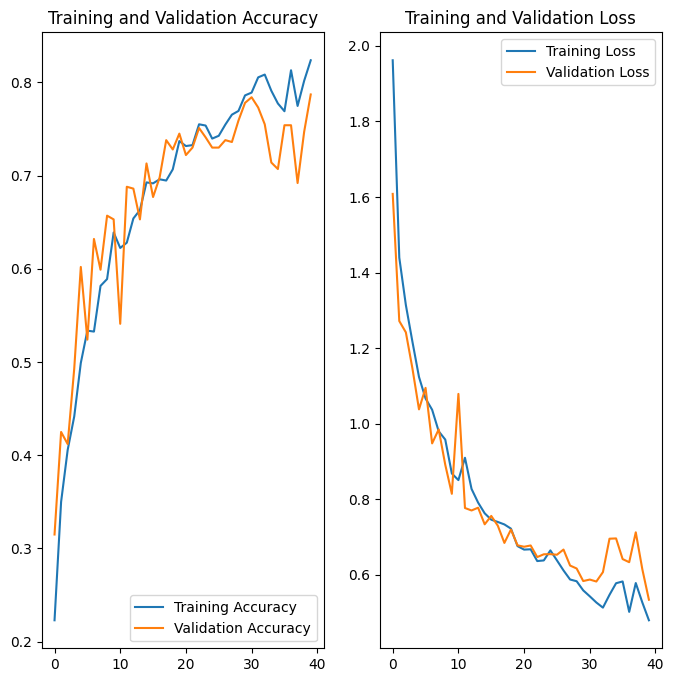

In [17]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
predIdxs = model.predict(x_test, batch_size=BS, verbose=0)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(np.argmax(y_test, axis=1), predIdxs, # labels transformed back to single unit
    target_names=lb.classes_))

              precision    recall  f1-score   support

           1       0.70      0.75      0.72       118
           2       0.55      0.66      0.60       126
           3       0.68      0.59      0.63       117
           4       0.78      0.76      0.77       122
           5       0.65      0.56      0.60       135
           6       0.74      0.72      0.73       133
           7       0.94      0.91      0.92       114
           8       0.94      0.99      0.96       135

    accuracy                           0.74      1000
   macro avg       0.75      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



In [ ]:
end_time = time.time()

In [24]:
print("Duration: ", (end_time - start_time), "seconds")

Duration:  674.3852150440216 seconds


In [25]:
print("Time per Epoch: ", (end_time - start_time)/40, "seconds")

Time per Epoch:  16.85963037610054 seconds
